# Workbook 03 - Dimension Reduction
by [David Elliott](https://eldave93.netlify.app/)

1. [Workspace Setup](#setup)

2. [Problem Understanding](#problem)

3. [Data Pre-Processing/EDA](#eda)
   
__Notes__
- Still experimenting with what dataset might be a good shout to demo this...
- The divorse seems the model is too good from the beginning, but the data is interesting.
- Cars seems like a good shout as improvments are minimal. Could look at categorical features as well.

This workbook we are going to be looking at how we can reduce the number of attributes to those that might be useful for our model. We've been so far working with data with a few attributes (features), but sometimes you have lots of attributes and don't know where to start!

In order to reduce a models complexity, run time, and potential for overfitting to the training data, dimension reduction techniques can be used. Broadly they can be grouped into methods that create a subset of the original set of features (Feature Selection) and methods that create new synthetic features through combining the original features and discarding less important ones (Feature Extraction). Essentially we want to remove "uninformative infromation" and retain useful bits<sup>1</sup>. If you have too many features, it may be that some of them are highly correlated and therefore redundant. Therefore we can either select just some of them, or compress them onto a lower dimensional subspace<sup>2</sup>.

---
1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

2. Raschka, 2016

# 1. Workspace Setup

Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.A. Google Colab
If you are not using google colab then you can skip this section. 

If you are using colab we will first need to have the libaries for the runtime and files associated with this workbook uploaded to the temporary file store. You also need to set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. The below code will do all this for you.

__Required:__ After running this code make sure to restart the runtime to ensure everything works correctly (Runtime > Restart runtime).

In [1]:
import sys
import os

try:
    import google.colab
    COLAB=True
    
    # set the workbook code
    WORKSHOP_NAME = "03-dimension-reduction"
    # set the folder name
    FOLDER_NAME = "machine-learning-workbooks-main"

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists(FOLDER_NAME):
        # get the zip of the workbooks
        !wget https://github.com/Eldave93/machine-learning-workbooks/archive/refs/heads/main.zip
        # unzip the file
        !unzip main.zip
        # install the libaries
        !{sys.executable} -m pip install -r ./{FOLDER_NAME}/scripts/requirements.txt
          
    print("Setting working directory to:")
    %cd ./{FOLDER_NAME}/{WORKSHOP_NAME}
    
except:
    COLAB=False
    print("Colab is not being used")

Colab is not being used


## 1.1. Packages

If your using a local workspace you will need all the following packages to run this notebook. If you do not already have them, or you want to ensure you are using the same versions as used when created, you could run `!{sys.executable} -m pip install -r ../scripts/requirements.txt` to install them for you.

In [2]:
import os # locating directories
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings # prevent warnings

sys.path.append('../scripts') # add scripts to the path for use later
sns.set(rc={'figure.figsize': (14, 8)}) # For plot sizes
np.random.seed(42)  # to make this notebook's output identical at every run

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 1.2. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workbook folder (e.g. `03-dimension-reduction`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).
- This may not work if you don't have the same version of `IPython.display` as the machine that created them:
    ```
    ImportError: cannot import name 'Code' from 'IPython.display' (/usr/local/lib/python3.7/dist-packages/IPython/display.py)
    ```
    If so run the auto-install above or manually run `!pip install ipython==7.20`.

---

# 2. Problem Understanding <a id='problem'></a>

# News pop
__TODO:__ maybe this data will be a good one to look at NLP? You could recreate the metrics and compare?

In [3]:
# download from the sourse
import requests
import zipfile

if not os.path.exists("./Data/OnlineNewsPopularity.zip"):
    r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip")
    open("./Data/OnlineNewsPopularity.zip" , 'wb').write(r.content)

if not os.path.exists("./Data/OnlineNewsPopularity.csv") or not os.path.exists("./Data/OnlineNewsPopularity.names"):
    # unzip the file
    with zipfile.ZipFile("./Data/OnlineNewsPopularity.zip", 'r') as zip_ref:
        zip_ref.extractall("./Data/OnlineNewsPopularity")
    
    # change the location/tidy up
    os.rename("./Data/OnlineNewsPopularity/OnlineNewsPopularity/OnlineNewsPopularity.csv", "./Data/OnlineNewsPopularity.csv")
    os.rename("./Data/OnlineNewsPopularity/OnlineNewsPopularity/OnlineNewsPopularity.names", "./Data/OnlineNewsPopularity.names")
    os.rmdir("./Data/OnlineNewsPopularity/OnlineNewsPopularity")
    os.rmdir("./Data/OnlineNewsPopularity")

In [4]:
news_df = pd.read_csv("./Data/OnlineNewsPopularity.csv")
news_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [5]:
# data dictionary
news_info = open("./Data/OnlineNewsPopularity.names", "r")
for i, line in enumerate(news_info):
    if i>40 and i<111:
        print(line)

news_info.close()

     0. url:                           URL of the article

     1. timedelta:                     Days between the article publication and

                                       the dataset acquisition

     2. n_tokens_title:                Number of words in the title

     3. n_tokens_content:              Number of words in the content

     4. n_unique_tokens:               Rate of unique words in the content

     5. n_non_stop_words:              Rate of non-stop words in the content

     6. n_non_stop_unique_tokens:      Rate of unique non-stop words in the

                                       content

     7. num_hrefs:                     Number of links

     8. num_self_hrefs:                Number of links to other articles

                                       published by Mashable

     9. num_imgs:                      Number of images

    10. num_videos:                    Number of videos

    11. average_token_length:          Average length of the words in t

In [6]:
# remove spaces in columns name character
news_df.columns = news_df.columns.str.replace(' ', '')
# remove the non-predictive information from the data
news_df.drop(["url", "timedelta"], axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(news_df, random_state=42)

X_train, y_train = train_set.drop("shares", axis=1), train_set["shares"]
X_test, y_test = test_set.drop("shares", axis=1), test_set["shares"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29733, 58)
(29733,)
(9911, 58)
(9911,)


In [8]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

print("Highest class proportion: " + str(round(pd.Series(y_train).value_counts(normalize=True).max(), 3)))

scores = cross_validate(DummyRegressor(), X_train, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

Highest class proportion: 0.058


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.0,-0.0,0.0
1,0.00,0.0,-0.0,0.0
2,0.01,0.0,-0.0,0.0
3,0.01,0.0,-0.0,0.0
4,0.01,0.0,-0.0,0.0
mean,0.01,0.0,-0.0,0.0
sd,0.00,0.0,0.0,0.0


In [9]:
from sklearn.linear_model import LinearRegression

#log_pipe = Pipeline(pre_processing)
lin_pipe = LinearRegression()

display(lin_pipe)

tidy_scores(cross_validate(lin_pipe, X_train, y_train, cv=5, return_train_score=True, verbose=2))

LinearRegression()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.09,0.01,0.01,0.03
1,0.07,0.00,0.03,0.02
2,0.06,0.00,0.04,0.02
3,0.07,0.00,0.01,0.03
4,0.07,0.00,-5.67,0.02
mean,0.07,0.00,-1.12,0.02
sd,0.01,0.00,2.28,0.00


In [10]:
from scipy import stats
import numpy as np

column_names = X_train.columns

for i in range(X_train.shape[-1]):

    corr = pd.DataFrame(stats.pearsonr(X_train.iloc[:,i], y_train), 
                        index = ["cor", "p-value"],
                        columns = [column_names[i]])
    if i ==0:
        all_corr = corr
    else:
        all_corr = pd.concat([all_corr, corr], axis = 1)
        
display(all_corr.round(3).sort_values(by="cor", axis=1).T)

,cor,p-value
LDA_02,-0.060,0.000
data_channel_is_world,-0.051,0.000
avg_negative_polarity,-0.025,0.000
average_token_length,-0.021,0.000
max_negative_polarity,-0.019,0.001
data_channel_is_bus,-0.017,0.003
data_channel_is_entertainment,-0.016,0.005
LDA_04,-0.014,0.014
LDA_01,-0.012,0.045
rate_negative_words,-0.012,0.044


In [11]:
# filter only correlations stronger than .1 in either direction (positive or negative)
corrs = all_corr.loc["p-value"]<0.05
pd.DataFrame(X_train.loc[:,corrs]).head()

,n_tokens_title,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_world,kw_max_min,...,LDA_04,global_subjectivity,global_sentiment_polarity,rate_negative_words,avg_positive_polarity,avg_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity
2361,9.0,37.0,8.0,1.0,5.837004,8.0,0.0,0.0,1.0,635.0,...,0.123169,0.434722,-0.106597,0.800000,0.250000,-0.214583,-0.100000,0.000,0.000000,0.000000
3480,10.0,7.0,1.0,0.0,4.358779,10.0,1.0,0.0,0.0,634.0,...,0.124486,0.533107,0.110035,0.281250,0.339526,-0.386420,-0.155556,0.850,0.091667,0.091667
6758,9.0,4.0,0.0,1.0,5.078788,5.0,1.0,0.0,0.0,919.0,...,0.040000,0.336765,0.048529,0.428571,0.281250,-0.100000,-0.050000,0.000,0.000000,0.000000
32204,10.0,13.0,1.0,0.0,5.072110,4.0,0.0,0.0,1.0,0.0,...,0.050003,0.343841,0.055903,0.393939,0.297987,-0.217628,-0.125000,0.175,0.000000,0.000000
13041,12.0,7.0,0.0,1.0,4.095420,9.0,0.0,0.0,0.0,731.0,...,0.910532,0.453349,0.120298,0.230769,0.292208,-0.270370,-0.155556,0.000,0.000000,0.000000


In [12]:
tidy_scores(cross_validate(lin_pipe, pd.DataFrame(X_train.loc[:,corrs]), y_train, cv=5, return_train_score=True, verbose=2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.04,0.00,0.01,0.03
1,0.03,0.00,0.03,0.02
2,0.04,0.01,0.04,0.02
3,0.03,0.00,0.01,0.02
4,0.03,0.01,0.04,0.02
mean,0.03,0.01,0.02,0.02
sd,0.00,0.00,0.01,0.00


In [13]:
y_train_ = (y_train<1400)*1
y_train_

2361     0
3480     0
6758     0
32204    1
13041    0
        ..
6265     0
11284    1
38158    1
860      0
15795    1
Name: shares, Length: 29733, dtype: int32

In [14]:
from sklearn.dummy import DummyClassifier
scores = cross_validate(DummyClassifier(), X_train, y_train_, cv=5, return_train_score=True)
tidy_scores(scores)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.0,0.54,0.54
1,0.01,0.0,0.54,0.54
2,0.01,0.0,0.54,0.54
3,0.02,0.0,0.54,0.54
4,0.01,0.0,0.54,0.54
mean,0.01,0.0,0.54,0.54
sd,0.00,0.0,0.00,0.00


In [15]:
from sklearn.linear_model import LogisticRegression

#log_pipe = Pipeline(pre_processing)
log_pipe = LogisticRegression()

display(log_pipe)

tidy_scores(cross_validate(log_pipe, X_train, y_train_, cv=5, return_train_score=True, verbose=2))

LogisticRegression()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   0.1s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   0.2s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.30,0.0,0.58,0.59
1,0.23,0.0,0.61,0.59
2,0.28,0.0,0.59,0.59
3,0.25,0.0,0.58,0.60
4,0.21,0.0,0.60,0.59
mean,0.25,0.0,0.59,0.59
sd,0.03,0.0,0.01,0.00


In [16]:
from sklearn.linear_model import LogisticRegression

#log_pipe = Pipeline(pre_processing)
log_pipe = LogisticRegression()

display(log_pipe)

tidy_scores(cross_validate(log_pipe, pd.DataFrame(X_train.loc[:,corrs]), y_train_, cv=5, return_train_score=True, verbose=2))

LogisticRegression()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.16,0.00,0.57,0.56
1,0.16,0.00,0.56,0.57
2,0.14,0.01,0.56,0.57
3,0.16,0.00,0.56,0.57
4,0.15,0.00,0.57,0.57
mean,0.15,0.00,0.57,0.57
sd,0.01,0.00,0.00,0.00


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(criterion='gini',
                                                               n_estimators=10,
                                                               max_features = 5,
                                                               random_state=0,
                                                               n_jobs=-1), 
                                        threshold = 'mean')),
  ('classification', LogisticRegression())
])

tidy_scores(cross_validate(clf, X_train, y_train_, cv=5, return_train_score=True, verbose=2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .................................................... total time=   2.5s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   0.5s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   0.4s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s


C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,2.52,0.04,0.58,0.57
1,0.55,0.04,0.57,0.56
2,0.46,0.04,0.56,0.56
3,0.46,0.04,0.56,0.57
4,0.52,0.05,0.56,0.56
mean,0.90,0.05,0.56,0.57
sd,0.81,0.00,0.01,0.00


# divorse
__Notes__ I had to use 7-zip to extract the data https://archive.ics.uci.edu/ml/machine-learning-databases/00497/divorce.rar

In [18]:
divorse_df = pd.read_excel("./Data/divorce/divorce.xlsx")
divorse_df.head()

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(divorse_df, random_state=42)

X_train, y_train = train_set.drop("Class", axis=1), train_set["Class"]
X_test, y_test = test_set.drop("Class", axis=1), test_set["Class"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127, 54)
(127,)
(43, 54)
(43,)


In [20]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

print("Highest class proportion: " + str(round(pd.Series(y_train).value_counts(normalize=True).max(), 3)))

scores = cross_validate(DummyClassifier(), X_train, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

Highest class proportion: 0.52


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,0.54,0.51
1,0.0,0.0,0.50,0.52
2,0.0,0.0,0.52,0.52
3,0.0,0.0,0.52,0.52
4,0.0,0.0,0.52,0.52
mean,0.0,0.0,0.52,0.52
sd,0.0,0.0,0.01,0.00


In [21]:
from sklearn.linear_model import LogisticRegression

#log_pipe = Pipeline(pre_processing)
log_pipe = LogisticRegression()

display(log_pipe)

tidy_scores(cross_validate(log_pipe, X_train, y_train, cv=5, return_train_score=True, verbose=2))

LogisticRegression()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.0,0.96,1.0
1,0.01,0.0,0.96,1.0
2,0.01,0.0,0.96,1.0
3,0.01,0.0,1.00,1.0
4,0.00,0.0,1.00,1.0
mean,0.01,0.0,0.98,1.0
sd,0.00,0.0,0.02,0.0


In [22]:
from scipy import stats
import numpy as np

column_names = X_train.columns

for i in range(X_train.shape[-1]):

    corr = pd.DataFrame(stats.pearsonr(X_train.iloc[:,i], y_train), 
                        index = ["cor", "p-value"],
                        columns = [column_names[i]])
    if i ==0:
        all_corr = corr
    else:
        all_corr = pd.concat([all_corr, corr], axis = 1)
        
display(all_corr.round(3).sort_values(by="cor", axis=1).T)

,cor,p-value
Atr6,0.445,0.0
Atr46,0.473,0.0
Atr45,0.539,0.0
Atr43,0.541,0.0
Atr7,0.572,0.0
Atr48,0.585,0.0
Atr52,0.614,0.0
Atr47,0.653,0.0
Atr51,0.669,0.0
Atr53,0.691,0.0


In [23]:
# filter only correlations stronger than .1 in either direction (positive or negative)
corrs = all_corr.loc["cor"]>0.9
pd.DataFrame(X_train.loc[:,corrs]).head()

,Atr9,Atr11,Atr15,Atr17,Atr18,Atr19,Atr20,Atr36,Atr38,Atr40
146,0,0,0,1,0,1,0,0,0,1
137,1,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0
65,3,3,3,3,3,3,3,3,3,3
36,3,4,3,4,3,4,3,3,4,4


In [24]:
from sklearn.linear_model import LogisticRegression

#log_pipe = Pipeline(pre_processing)
log_pipe = LogisticRegression()

display(log_pipe)

tidy_scores(cross_validate(log_pipe, pd.DataFrame(X_train.loc[:,corrs]), y_train, cv=5, return_train_score=True, verbose=2))

LogisticRegression()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.0,0.96,1.00
1,0.01,0.0,0.96,0.99
2,0.01,0.0,1.00,0.99
3,0.01,0.0,1.00,0.99
4,0.00,0.0,1.00,0.99
mean,0.01,0.0,0.98,0.99
sd,0.00,0.0,0.02,0.00


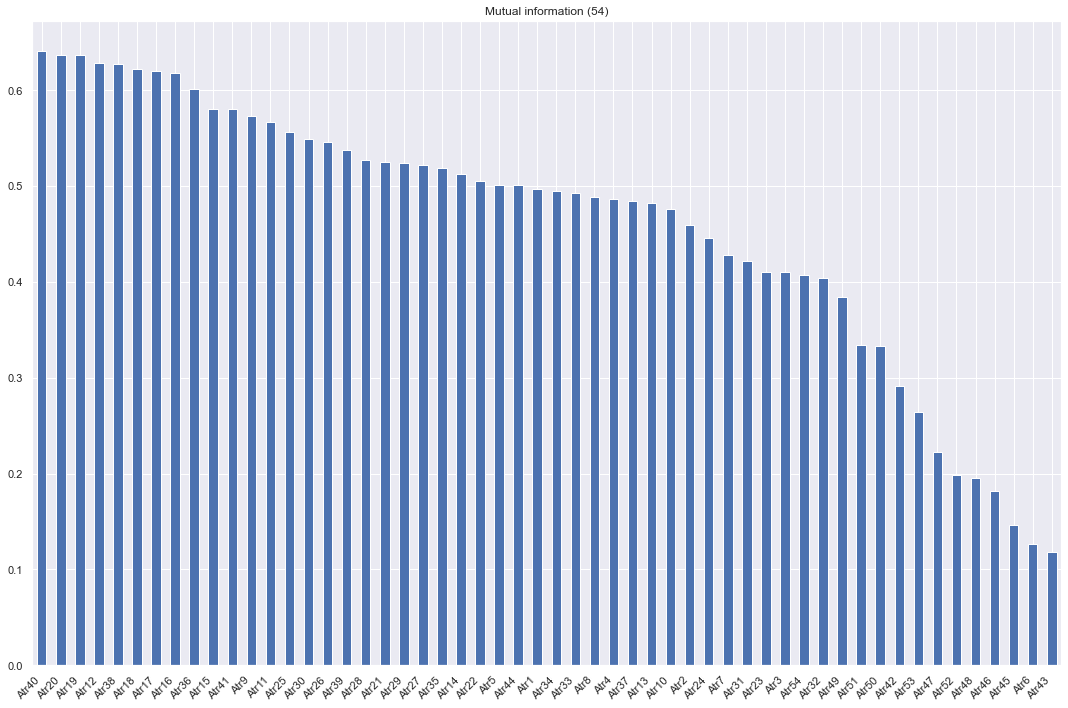

In [25]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize=(15,10))

mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending = False)

# lets plot the top 30
PLOT_NUM = 54
mi_series[:PLOT_NUM].plot.bar(legend = False, figsize=(15,10))
plt.title('Mutual information (' + str(PLOT_NUM) + ')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
#plt.savefig('mutual_information.png', dpi=300)
plt.show()

In [26]:
# filter only correlations stronger than .1 in either direction (positive or negative)
mis = mi_series>0.6
pd.DataFrame(X_train.loc[:,mis]).head()

,Atr12,Atr16,Atr17,Atr18,Atr19,Atr20,Atr36,Atr38,Atr40
146,1,0,1,0,1,0,0,0,1
137,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0
65,3,2,3,3,3,3,3,3,3
36,3,3,4,3,4,3,3,4,4


In [27]:
tidy_scores(cross_validate(log_pipe, pd.DataFrame(X_train.loc[:,mis]), y_train, cv=5, return_train_score=True, verbose=2))

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.01,0.0,0.96,1.00
1,0.00,0.0,0.96,0.99
2,0.00,0.0,0.96,0.99
3,0.00,0.0,1.00,0.99
4,0.01,0.0,1.00,0.99
mean,0.00,0.0,0.98,0.99
sd,0.00,0.0,0.02,0.00


# Cars
https://archive.ics.uci.edu/ml/datasets/Automobile

In [28]:
# data dictionary
cars_info = open("./Data/imports-85.names", "r")
for i, line in enumerate(cars_info):
    if i>56 and i<90:
        print(line)

cars_info.close()

7. Attribute Information:     

     Attribute:                Attribute Range:

     ------------------        -----------------------------------------------

  1. symboling:                -3, -2, -1, 0, 1, 2, 3.

  2. normalized-losses:        continuous from 65 to 256.

  3. make:                     alfa-romero, audi, bmw, chevrolet, dodge, honda,

                               isuzu, jaguar, mazda, mercedes-benz, mercury,

                               mitsubishi, nissan, peugot, plymouth, porsche,

                               renault, saab, subaru, toyota, volkswagen, volvo

  4. fuel-type:                diesel, gas.

  5. aspiration:               std, turbo.

  6. num-of-doors:             four, two.

  7. body-style:               hardtop, wagon, sedan, hatchback, convertible.

  8. drive-wheels:             4wd, fwd, rwd.

  9. engine-location:          front, rear.

 10. wheel-base:               continuous from 86.6 120.9.

 11. length:                   continuous 

In [29]:
cars_cols = ["symboling", "normalized-losses", "make", "fuel-type",
             "aspiration", "num-of-doors", "body-style", "drive-wheels",
             "engine-location", "wheel-base", "length", "width", "height",
             "curb-weight", "engine-type", "num-of-cylinders", "engine-size",
             "fuel-system", "bore", "stroke", "compression-ratio", "horsepower",
             "peak-rpm", "city-mpg", "highway-mpg", "price"
            ]

In [30]:
cars_df = pd.read_csv("./Data/imports-85.data", names = cars_cols, na_values="?")
cars_df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [31]:
cars_df.dropna(inplace=True)

In [32]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int64  
 1   normalized-losses  159 non-null    float64
 2   make               159 non-null    object 
 3   fuel-type          159 non-null    object 
 4   aspiration         159 non-null    object 
 5   num-of-doors       159 non-null    object 
 6   body-style         159 non-null    object 
 7   drive-wheels       159 non-null    object 
 8   engine-location    159 non-null    object 
 9   wheel-base         159 non-null    float64
 10  length             159 non-null    float64
 11  width              159 non-null    float64
 12  height             159 non-null    float64
 13  curb-weight        159 non-null    int64  
 14  engine-type        159 non-null    object 
 15  num-of-cylinders   159 non-null    object 
 16  engine-size        159 non

In [33]:
cat_feats = list(cars_df.columns[cars_df.dtypes =="object"])
num_feats = list(cars_df.columns[cars_df.dtypes !="object"])
num_feats.remove('price')

not enough variation to be useful

In [34]:
display(cars_df["engine-location"].value_counts())
cars_df.drop("engine-location", axis=1, inplace=True)
cat_feats.remove('engine-location')

front    159
Name: engine-location, dtype: int64

In [35]:
# this is questionable but just checking
display(cars_df["fuel-system"].value_counts())
cars_df = cars_df[cars_df["fuel-system"] != "mfi"]
display(cars_df["make"].value_counts())
cars_df = cars_df[cars_df["make"] != "jaguar"]
cars_df = cars_df[cars_df["make"] != "porsche"]

mpfi    64
2bbl    63
idi     15
1bbl    11
spdi     5
mfi      1
Name: fuel-system, dtype: int64

toyota           31
nissan           18
honda            13
subaru           12
mazda            11
volvo            11
mitsubishi       10
volkswagen        8
peugot            7
dodge             7
plymouth          6
saab              6
mercedes-benz     5
bmw               4
audi              4
chevrolet         3
jaguar            1
porsche           1
Name: make, dtype: int64

In [36]:
display(cars_df["body-style"].value_counts())

sedan          78
hatchback      54
wagon          17
hardtop         5
convertible     2
Name: body-style, dtype: int64

In [37]:
cars_df["num-of-cylinders"] = cars_df["num-of-cylinders"].map(
    {"eight":8, "five":5, "four":4, "six":6, "three":3, "twelve":12, "two":2}
)

cars_df["num-of-doors"] = cars_df["num-of-doors"].map({"four":4, "two":2})

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
onehot_transform = ColumnTransformer(
    [("encode", OneHotEncoder(), cat_feats)], remainder="passthrough").fit(cars_df)

cars_df_ = pd.DataFrame(onehot_transform.transform(cars_df), columns = onehot_transform.get_feature_names_out())

cars_df_.columns = cars_df_.columns.str.replace('encode__', '')
cars_df_.columns = cars_df_.columns.str.replace('remainder__', '')
cars_df_

,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_mazda,make_mercedes-benz,make_mitsubishi,make_nissan,make_peugot,...,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2844.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,17710.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3086.0,131.0,3.13,3.40,8.3,140.0,5500.0,17.0,20.0,23875.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2395.0,108.0,3.50,2.80,8.8,101.0,5800.0,23.0,29.0,16430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2952.0,141.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0,16845.0
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3049.0,141.0,3.78,3.15,8.7,160.0,5300.0,19.0,25.0,19045.0
153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3012.0,173.0,3.58,2.87,8.8,134.0,5500.0,18.0,23.0,21485.0
154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3217.0,145.0,3.01,3.40,23.0,106.0,4800.0,26.0,27.0,22470.0


In [39]:
'''
from sklearn.preprocessing import StandardScaler
scale_transform = ColumnTransformer(
        [("scale", StandardScaler(),  num_feats)], 
        remainder="passthrough").fit(cars_df_)

cars_df_ = pd.DataFrame(scale_transform.transform(cars_df_), columns = scale_transform.get_feature_names_out())

cars_df_.columns = cars_df_.columns.str.replace('scale__', '')
cars_df_.columns = cars_df_.columns.str.replace('remainder__', '')
cars_df_
'''

'\nfrom sklearn.preprocessing import StandardScaler\nscale_transform = ColumnTransformer(\n        [("scale", StandardScaler(),  num_feats)], \n        remainder="passthrough").fit(cars_df_)\n\ncars_df_ = pd.DataFrame(scale_transform.transform(cars_df_), columns = scale_transform.get_feature_names_out())\n\ncars_df_.columns = cars_df_.columns.str.replace(\'scale__\', \'\')\ncars_df_.columns = cars_df_.columns.str.replace(\'remainder__\', \'\')\ncars_df_\n'

In [40]:
#cars_df.drop(["symboling", "make", "fuel-type", "aspiration", 
#              "body-style", "drive-wheels",
#              "engine-location","engine-type",
#              "fuel-system"], 
#             axis=1, inplace=True)

In [41]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cars_df_, random_state=42)

X_train, y_train = train_set.drop("price", axis=1), train_set["price"]
X_test, y_test = test_set.drop("price", axis=1), test_set["price"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(117, 60)
(117,)
(39, 60)
(39,)


In [42]:
scores = cross_validate(DummyRegressor(), X_train, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,-0.08,0.0
1,0.0,0.0,-0.01,0.0
2,0.0,0.0,-0.09,0.0
3,0.0,0.0,-0.00,0.0
4,0.0,0.0,-0.01,0.0
mean,0.0,0.0,-0.04,0.0
sd,0.0,0.0,0.04,0.0


In [43]:
lin_pipe = LinearRegression()

display(lin_pipe)

tidy_scores(cross_validate(lin_pipe, X_train, y_train, cv=5, return_train_score=True, verbose=2))

LinearRegression()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.0,7.900000e-01,0.98
1,0.00,0.0,-6.978736e+17,0.98
2,0.03,0.0,-7.332774e+15,0.97
3,0.00,0.0,-2.867547e+16,0.98
4,0.00,0.0,8.700000e-01,0.98
mean,0.01,0.0,-1.467764e+17,0.98
sd,0.01,0.0,2.757488e+17,0.00


its weird because OLS regression should be scale invarient but scaling makes a huge difference here... Need to investiate more.

In [44]:
from scipy import stats
import numpy as np

column_names = X_train.columns

for i in range(X_train.shape[-1]):

    corr = pd.DataFrame(stats.pearsonr(X_train.iloc[:,i], y_train), 
                        index = ["cor", "p-value"],
                        columns = [column_names[i]])
    if i ==0:
        all_corr = corr
    else:
        all_corr = pd.concat([all_corr, corr], axis = 1)
        
display(all_corr.round(3).sort_values(by="cor", axis=1).T)

,cor,p-value
highway-mpg,-0.747,0.000
city-mpg,-0.722,0.000
drive-wheels_fwd,-0.667,0.000
num-of-cylinders_4,-0.652,0.000
fuel-system_2bbl,-0.581,0.000
aspiration_std,-0.430,0.000
engine-type_ohc,-0.307,0.001
body-style_hatchback,-0.287,0.002
fuel-type_gas,-0.216,0.020
make_mitsubishi,-0.191,0.040


In [45]:
# filter only correlations stronger than .1 in either direction (positive or negative)
corrs = all_corr.loc["cor"].abs()>0.7
pd.DataFrame(X_train.loc[:,corrs]).head()

,length,width,curb-weight,engine-size,horsepower,city-mpg,highway-mpg
26,167.5,65.2,2289.0,110.0,86.0,27.0,33.0
134,183.5,67.7,2976.0,171.0,161.0,20.0,24.0
79,186.7,68.4,3075.0,120.0,97.0,19.0,24.0
131,175.6,66.5,2414.0,122.0,92.0,27.0,32.0
36,177.8,66.5,2385.0,122.0,84.0,26.0,32.0


In [46]:
tidy_scores(cross_validate(lin_pipe, pd.DataFrame(X_train.loc[:,corrs]), y_train, cv=5, return_train_score=True, verbose=2))

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.00,0.60,0.84
1,0.01,0.00,0.87,0.80
2,0.00,0.00,0.74,0.82
3,0.00,0.01,0.79,0.82
4,0.00,0.00,0.73,0.83
mean,0.00,0.00,0.74,0.82
sd,0.00,0.00,0.09,0.01


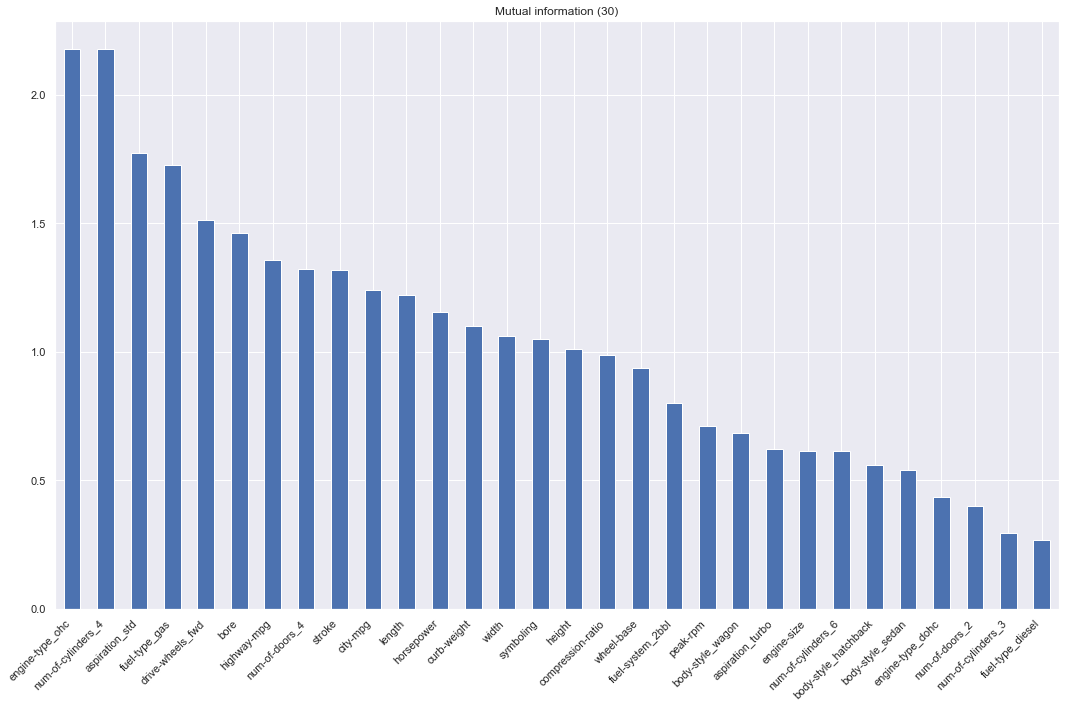

In [47]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize=(15,10))

mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending = False)

# lets plot the top 30
PLOT_NUM = 30
mi_series[:PLOT_NUM].plot.bar(legend = False, figsize=(15,10))
plt.title('Mutual information (' + str(PLOT_NUM) + ')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
#plt.savefig('mutual_information.png', dpi=300)
plt.show()

In [48]:
# filter only correlations stronger than .1 in either direction (positive or negative)
mis = mi_series>0.55
pd.DataFrame(X_train.loc[:,mis]).head()

,fuel-type_gas,aspiration_std,aspiration_turbo,num-of-doors_4,body-style_hatchback,body-style_wagon,drive-wheels_fwd,engine-type_ohc,num-of-cylinders_4,num-of-cylinders_6,...,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
26,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,53.3,2289.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
134,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,52.0,2976.0,171.0,3.27,3.35,9.3,161.0,5200.0,20.0,24.0
79,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,56.7,3075.0,120.0,3.46,3.19,8.4,97.0,5000.0,19.0,24.0
131,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,53.9,2414.0,122.0,3.31,3.54,8.7,92.0,4200.0,27.0,32.0
36,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,53.7,2385.0,122.0,3.39,3.39,8.6,84.0,4800.0,26.0,32.0


In [49]:
tidy_scores(cross_validate(lin_pipe, pd.DataFrame(X_train.loc[:,mis]), y_train, cv=5, return_train_score=True, verbose=2))

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.0,0.72,0.94
1,0.00,0.0,0.93,0.92
2,0.01,0.0,0.82,0.93
3,0.00,0.0,0.88,0.93
4,0.00,0.0,0.78,0.94
mean,0.00,0.0,0.83,0.93
sd,0.00,0.0,0.08,0.01
